In [100]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score

In [101]:
contaminated = pd.read_csv("../../data/contaminated/anomalieChatGpt.csv", header=None, names=['texte', 'anomalie'])
df_indices = pd.read_csv("../../data/contaminated/indices_anomalies.csv")
indices = df_indices['indice'].tolist()


In [102]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
def vetorisation_sbert(data, indice_anomalie=None):
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : normal)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

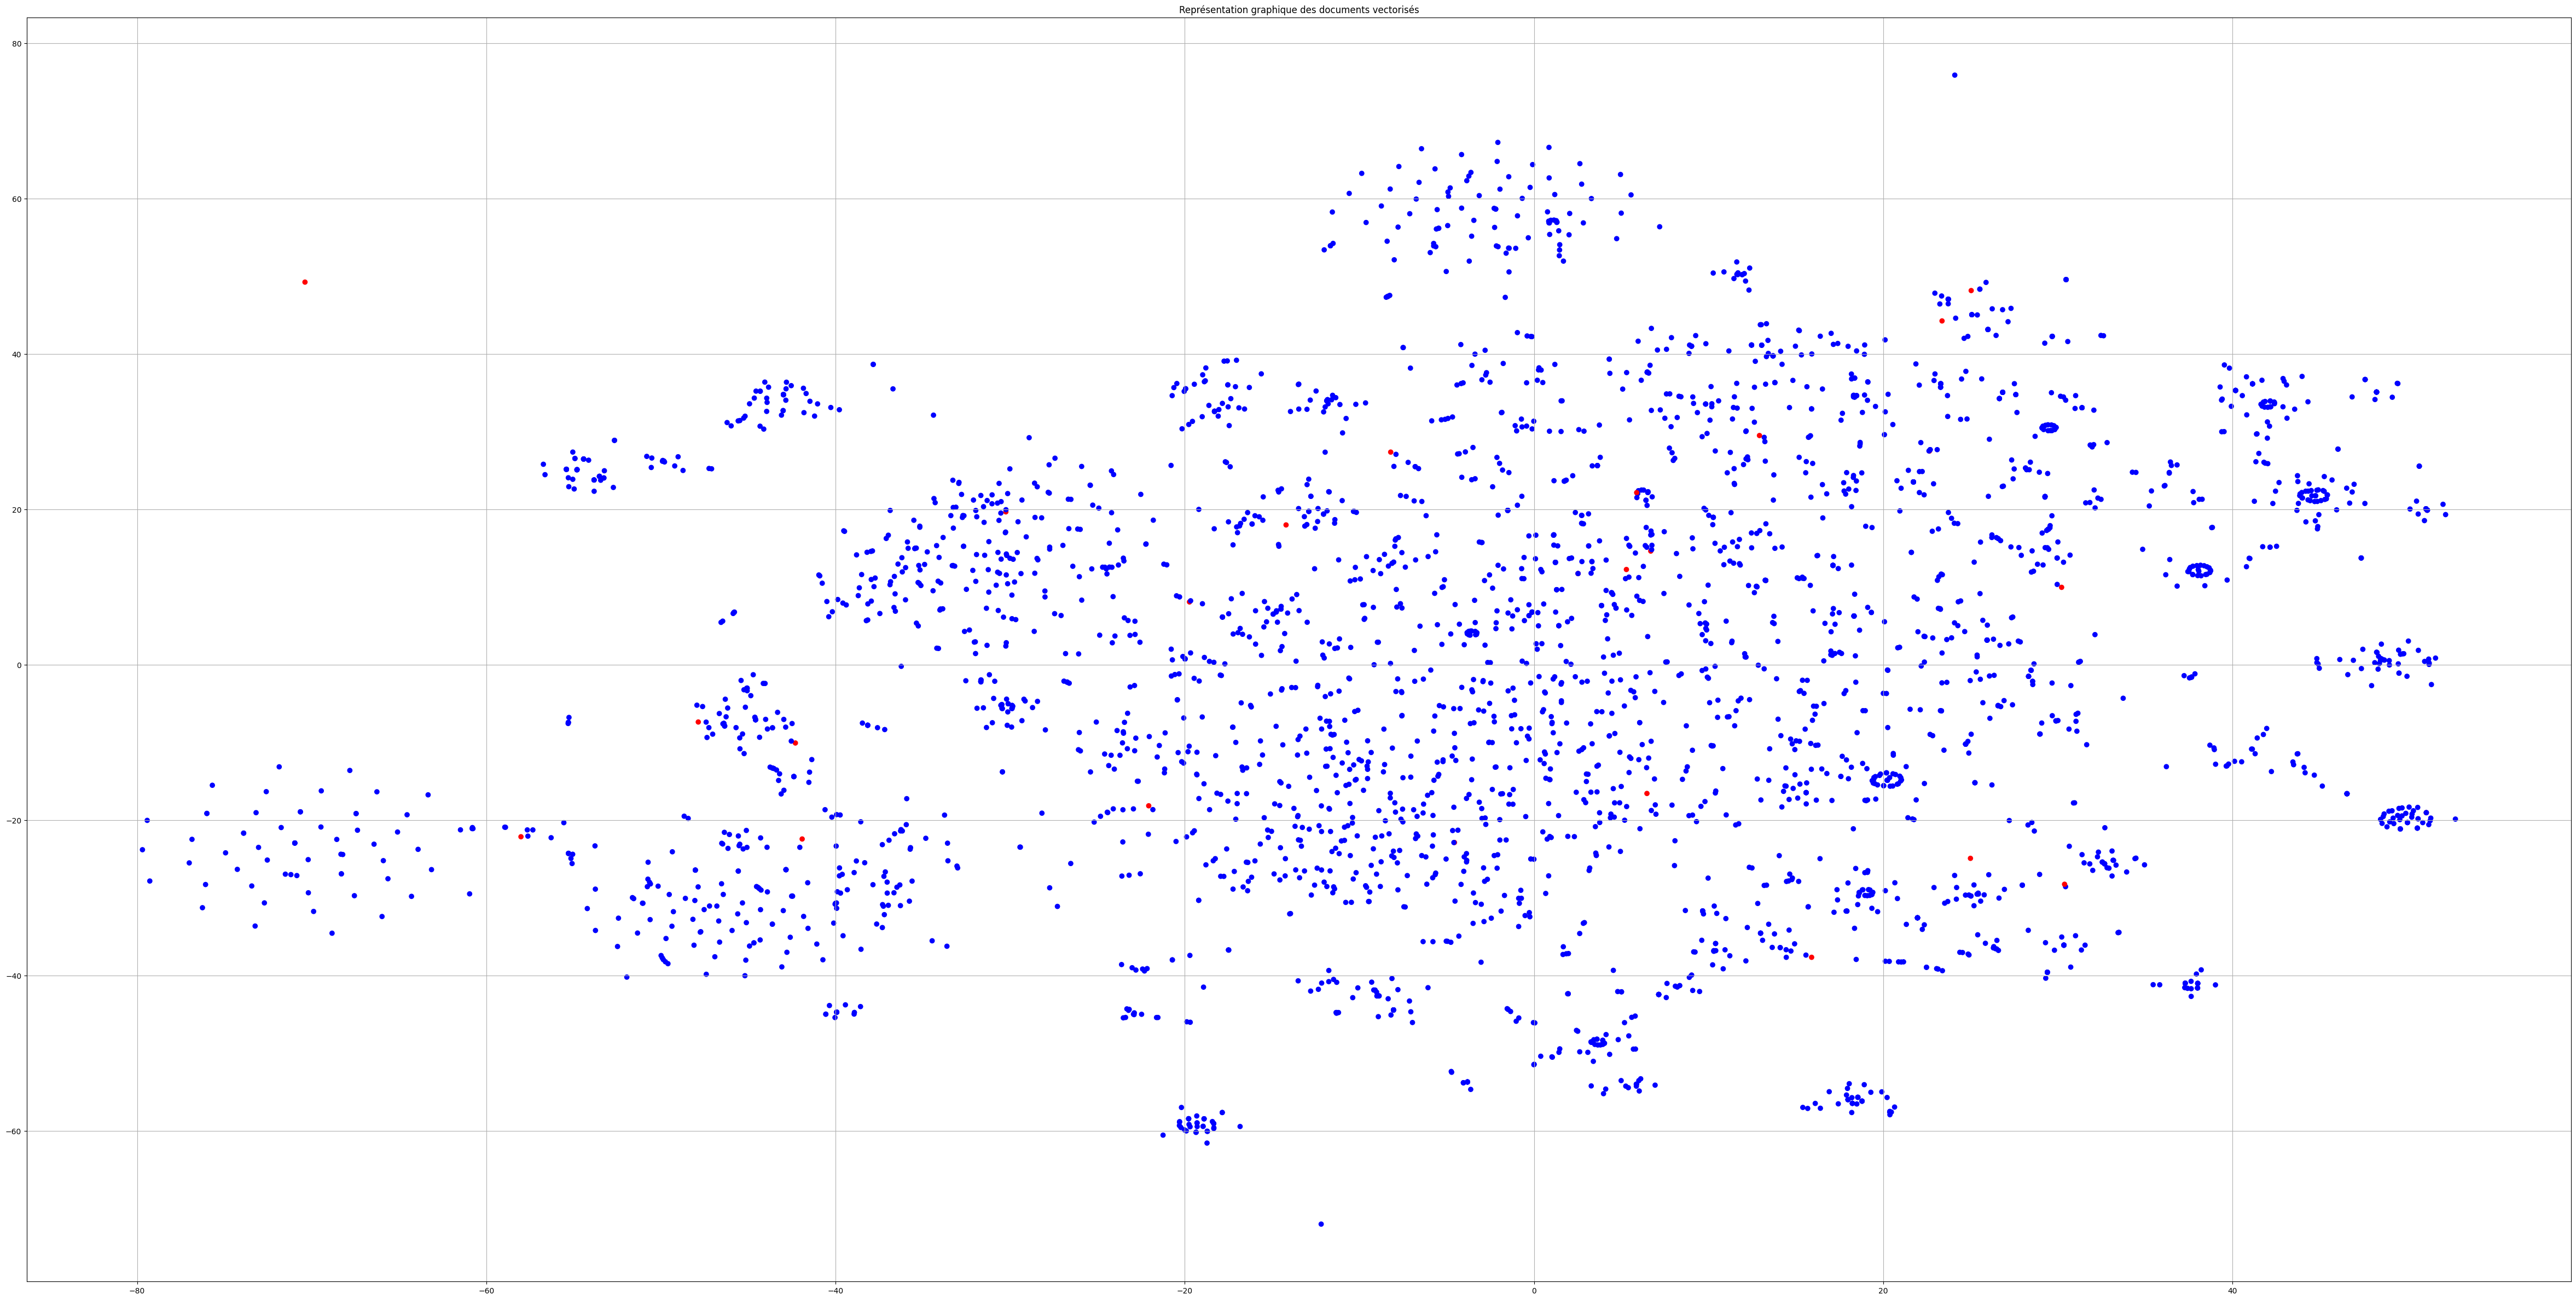

In [56]:
anomalie_sb = vetorisation_sbert(contaminated["texte"], indices)

In [103]:
tsne = TSNE(n_components=2, random_state=42)  
anomalie_sb = tsne.fit_transform(anomalie_sb)

anomaly_indices = indices  
normal_indices = list(set(contaminated.index) - set(anomaly_indices))

anomaly_train_idx, anomaly_test_idx = train_test_split(anomaly_indices, test_size=0.2, random_state=42)

normal_train_idx, normal_test_idx = train_test_split(normal_indices, test_size=0.2, random_state=42)

train_indices = anomaly_train_idx + normal_train_idx
test_indices = anomaly_test_idx + normal_test_idx

df_train = anomalie_sb[train_indices]
df_test = anomalie_sb[test_indices]

In [104]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [105]:
anomalie_tensor = torch.tensor(df_train, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=df_train.shape[1], latent_dim = 64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 163.7476
Epoch 2/50, Loss: 312.2972
Epoch 3/50, Loss: 21.9657
Epoch 4/50, Loss: 93.6106
Epoch 5/50, Loss: 78.3345
Epoch 6/50, Loss: 377.2598
Epoch 7/50, Loss: 147.0231
Epoch 8/50, Loss: 154.9013
Epoch 9/50, Loss: 82.0516
Epoch 10/50, Loss: 49.2404
Epoch 11/50, Loss: 100.3446
Epoch 12/50, Loss: 49.4806
Epoch 13/50, Loss: 217.1461
Epoch 14/50, Loss: 78.4244
Epoch 15/50, Loss: 207.4602
Epoch 16/50, Loss: 49.2361
Epoch 17/50, Loss: 53.3217
Epoch 18/50, Loss: 65.0547
Epoch 19/50, Loss: 228.8537
Epoch 20/50, Loss: 274.5032
Epoch 21/50, Loss: 80.2683
Epoch 22/50, Loss: 58.3278
Epoch 23/50, Loss: 58.3711
Epoch 24/50, Loss: 190.9047
Epoch 25/50, Loss: 59.0547
Epoch 26/50, Loss: 132.2780
Epoch 27/50, Loss: 127.4383
Epoch 28/50, Loss: 216.8683
Epoch 29/50, Loss: 81.8938
Epoch 30/50, Loss: 18.2136
Epoch 31/50, Loss: 46.3127
Epoch 32/50, Loss: 121.7638
Epoch 33/50, Loss: 26.2568
Epoch 34/50, Loss: 34.9844
Epoch 35/50, Loss: 8.7882
Epoch 36/50, Loss: 210.5653
Epoch 37/50, Loss: 394


 Meilleur seuil trouvé : 6.950779
 F1-score optimal : 0.0307

 Rapport de classification :

              precision    recall  f1-score   support

      Normal       1.00      0.52      0.69       661
    Anomalie       0.02      0.83      0.03         6

    accuracy                           0.53       667
   macro avg       0.51      0.68      0.36       667
weighted avg       0.99      0.53      0.68       667

AUC ROC : 0.6784
Average precision : 0.0145


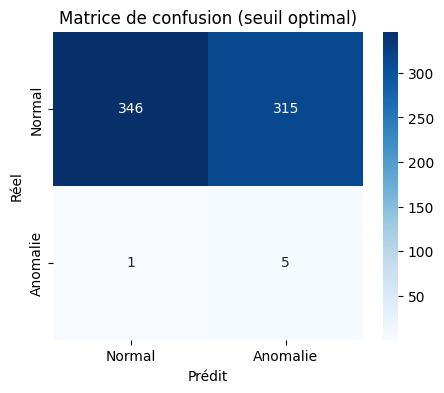

In [106]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(df_test, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn
# labels = [indices des anomalies connues]
labels = np.isin(test_indices, anomaly_test_idx).astype(int)

# le meilleur seuil basé sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n Meilleur seuil trouvé : {best_threshold:.6f}")
print(f" F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\n Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc = roc_auc_score(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")

# matrice de confusion 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()

In [98]:
mse_series = pd.Series(mse, name="MSE")
print(mse_series.describe())

count    667.000000
mean       6.977562
std        5.452903
min        0.339304
25%        2.570364
50%        5.619936
75%        9.822748
max       26.980442
Name: MSE, dtype: float64


In [109]:
isolation_forest = IsolationForest()
isolation_forest.fit(df_train)

IsolationForest()

In [110]:
i_forest = isolation_forest.decision_function(df_test)
anomaly_scores = -i_forest #anomalie >


📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.94       661
    Anomalie       0.04      0.50      0.07         6

    accuracy                           0.88       667
   macro avg       0.52      0.69      0.50       667
weighted avg       0.99      0.88      0.93       667

🎯 AUC ROC : 0.7179
Average precision : 0.0230


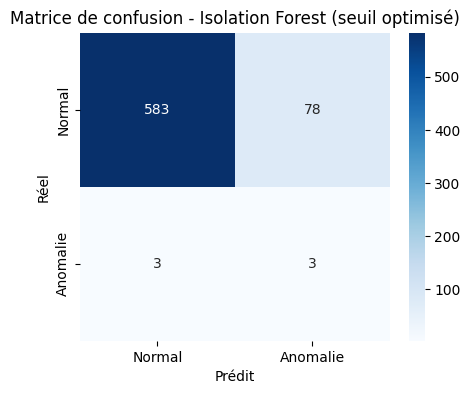

In [111]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\n📊 Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, anomaly_scores)

print(f"🎯 AUC ROC : {roc_auc:.4f}")
avg_precision = average_precision_score(y_true, y_pred)
print(f"Average precision : {avg_precision:.4f}")

# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisé)")
plt.show()

In [112]:
oc_svm = OneClassSVM(kernel='poly', gamma='scale') 
oc_svm.fit(df_train)

OneClassSVM(kernel='poly')

In [113]:
svm_pred = oc_svm.decision_function(df_test)
svm_scores = -svm_pred #anomalie >


 Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       661
    Anomalie       0.17      0.33      0.22         6

    accuracy                           0.98       667
   macro avg       0.58      0.66      0.61       667
weighted avg       0.99      0.98      0.98       667

 AUC ROC : 0.5464
Average precision : 0.0616


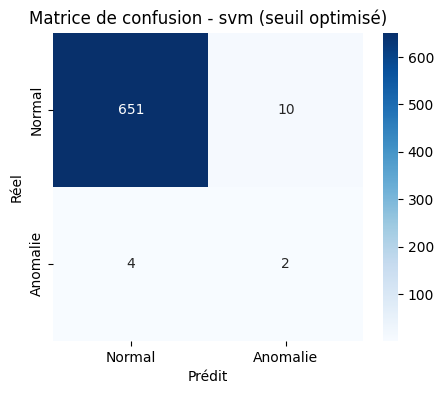

In [114]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\n Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, svm_scores)
avg_precision = average_precision_score(y_true, y_pred)

print(f" AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")

# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - svm (seuil optimisé)")
plt.show()